In [1]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 5
CHANNELS = 3


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


2024-09-20 16:50:08.561395: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 16:50:09.146492: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 16:50:11.319472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 16:50:13.790276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 2152 files belonging to 3 classes.


2024-09-20 16:50:19.789482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


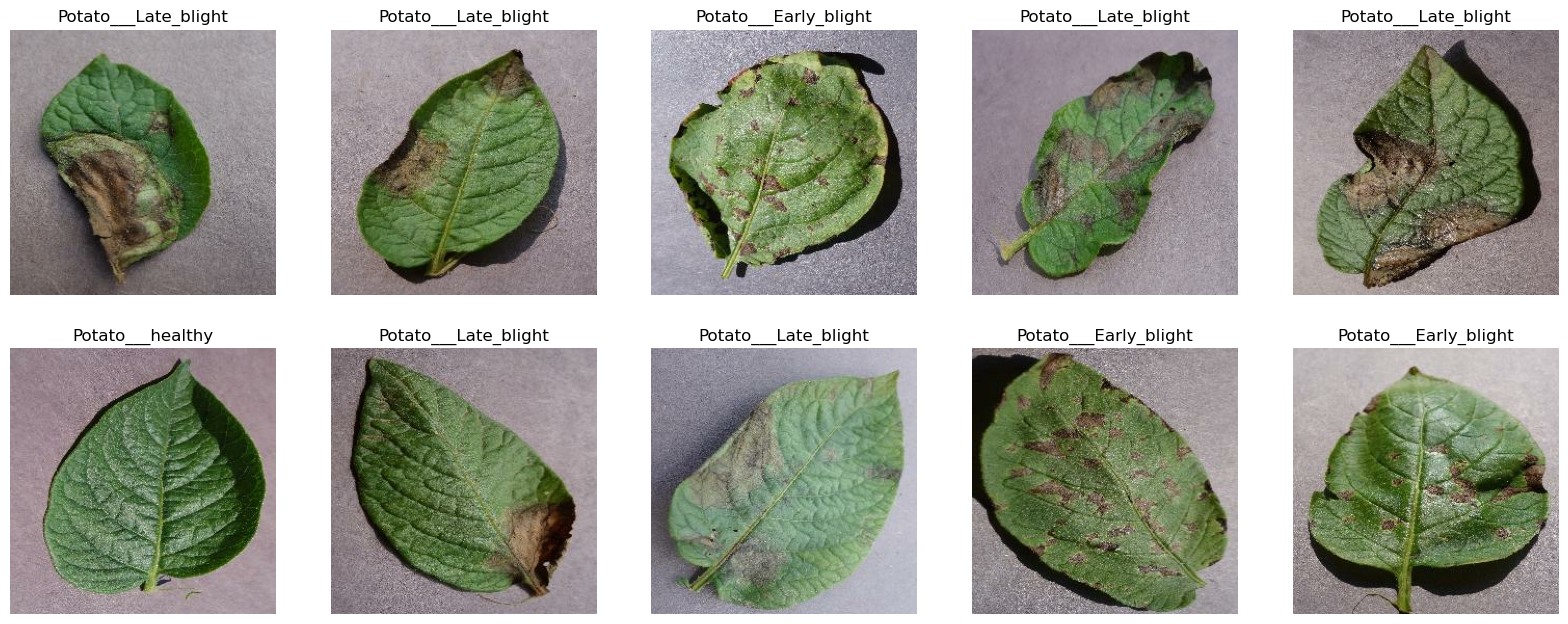

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,

    batch_size= BATCH_SIZE,
        image_size= (IMAGE_SIZE, IMAGE_SIZE)
)
class_names = dataset.class_names
plt.figure(figsize=(20,20))

for image, label in dataset.take(1):
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')
    



In [6]:
def do_data_partition(ds, train_split = 0.8, test_split = 0.1, val_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds = ds.shuffle(shuffle_size, seed = 12)
    ds_len = len(ds)
    train_size = int(train_split * ds_len)
    val_size = int(val_split * ds_len)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds



In [8]:
train_ds, val_ds, test_ds =  do_data_partition(dataset)
print(len(train_ds))

54


In [11]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(1./255),
])

In [18]:
input_shape= (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64,(3,3), activation = 'relu' ),
    layers.MaxPool2D(2,2),
    layers.Flatten(),
    layers.Dense(64,  activation = 'relu'),
    layers.Dense(3,  activation = 'softmax'),
    
])

In [19]:
model.build(input_shape = input_shape)
model.summary()
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Correct function call and argument
    metrics=['accuracy']
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 246016)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,675 (60.14 MB)

 Trainable params: 15,764,675 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
his  = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/5


2024-09-20 16:52:02.656212: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.
2024-09-20 16:52:03.890471: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.


 1/54 ━━━━━━━━━━━━━━━━━━━━ 4:11 5s/step - accuracy: 0.4062 - loss: 1.0886

2024-09-20 16:52:04.775695: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.
2024-09-20 16:52:05.803484: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264257536 exceeds 10% of free system memory.


54/54 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.5796 - loss: 2.8578 - val_accuracy: 0.8750 - val_loss: 0.4696
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8392 - loss: 0.4102 - val_accuracy: 0.9167 - val_loss: 0.2195
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9169 - loss: 0.2348 - val_accuracy: 0.8542 - val_loss: 0.2859
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9217 - loss: 0.1870 - val_accuracy: 0.9167 - val_loss: 0.1753
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.9498 - loss: 0.1339 - val_accuracy: 0.8906 - val_loss: 0.2391


In [21]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 509ms/step - accuracy: 0.8843 - loss: 0.2765


[0.2706037163734436, 0.88671875]

In [22]:
his.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [23]:
his.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [24]:
acc = his.history['accuracy']
val_acc = his.history['val_accuracy']
loss =  his.history['loss']
val_loss = his.history['val_loss']

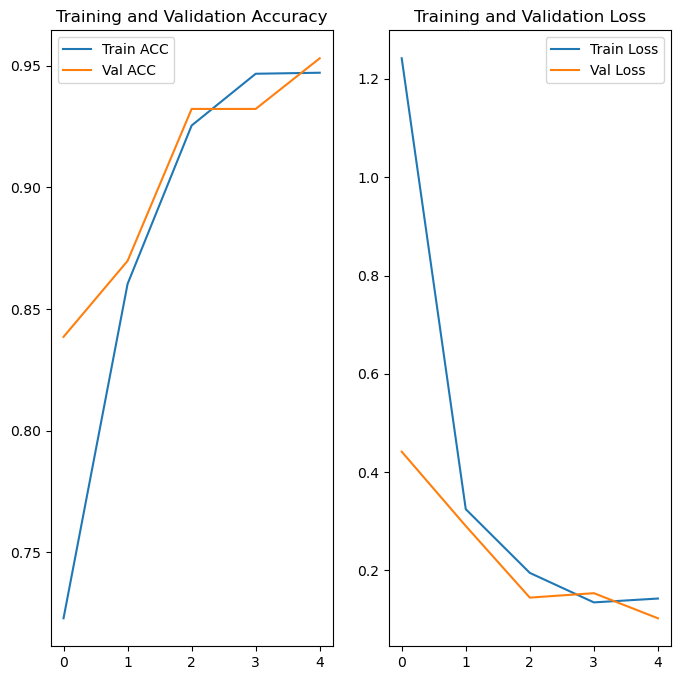

In [30]:
plt.figure(figsize=(8, 8))  # Corrected figsize argument with parentheses
plt.subplot(1, 2, 1)  # Subplot for the first plot (1 row, 2 columns, first plot)
plt.plot(range(EPOCHS), acc, label="Train ACC")  # Plot training accuracy
plt.plot(range(EPOCHS), val_acc, label="Val ACC")  # Plot validation accuracy
plt.title("Training and Validation Accuracy")
plt.legend()

# Optional: If you want to plot loss as well
plt.subplot(1, 2, 2)  # Subplot for the second plot (second plot)
plt.plot(range(EPOCHS), loss, label="Train Loss")
plt.plot(range(EPOCHS), val_loss, label="Val Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()  # Display the plots


LABEl -  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
PREDICTED -- Potato___Late_blight


2024-09-20 17:05:20.489642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


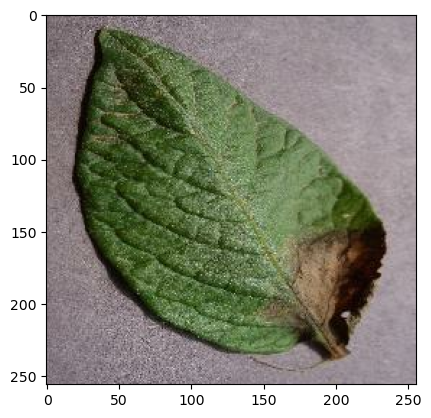

In [35]:
import numpy as np

for image_batch , labels_batch in test_ds.take(1):
    fm = image_batch[0].numpy().astype('uint8')
    fl = labels_batch[0]
    plt.imshow(fm)
    print('LABEl - ', class_names[fl])
    bp = model.predict(image_batch)
    print('PREDICTED --',class_names[np.argmax(bp[0])] )



In [37]:
def predict (model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    bp = model.predict(img_array)
    cl = class_names[np.argmax(bp[0])]
    confidenc = round(100 * np.max(bp[0]), 2)
    return cl, confidenc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2024-09-20 17:32:01.065000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


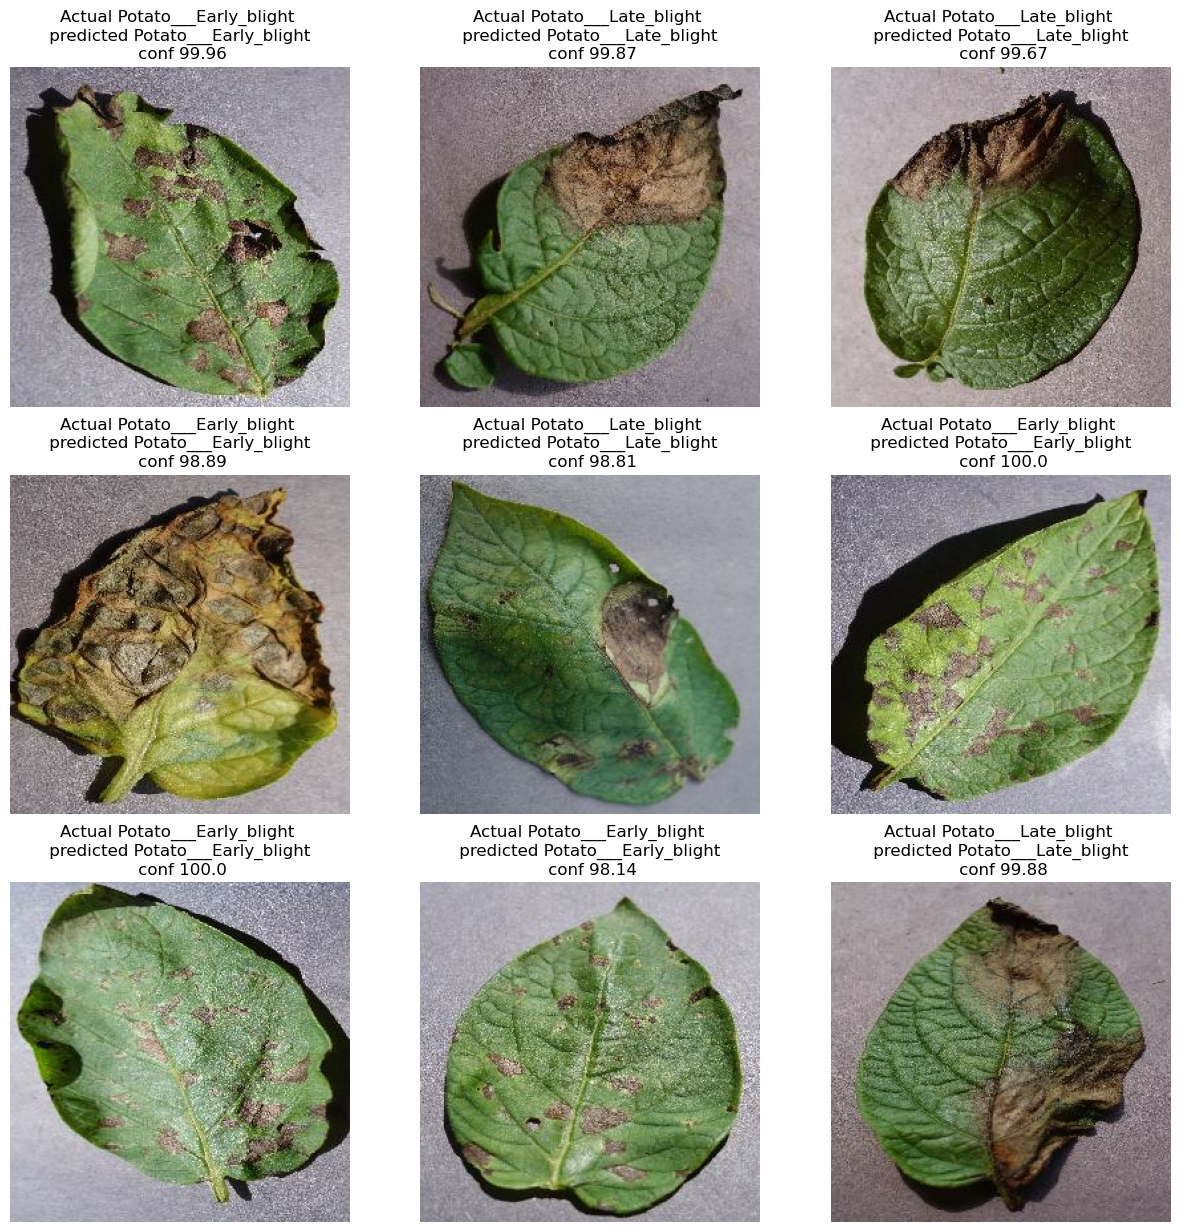

In [45]:
plt.figure(figsize=(15,15))
for images, lables in test_ds.take(1):
    for i in range (9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        pc, c = predict(model, images[i].numpy())
        ac_label = class_names[lables[i]]
        plt.title(f'Actual {ac_label} \n predicted {pc} \n conf {c}'   )


    

In [64]:
modelversion = 1
model.save(f"../models/{modelversion}")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=../models/1.